In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import cross_validate, ShuffleSplit,train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor

%matplotlib inline

#DummyRegressor
#SimpleImputer

# Agreed upon cleaned dataset

In [2]:
dataset = pd.read_csv('data/kc_house_data.csv')

# Null waterfront values count as no waterfront
dataset['waterfront'] = dataset['waterfront'].fillna(0) 

dataset['date'] = pd.to_datetime(dataset['date'])
# Drop how many times house viewed
dataset.dropna(subset = ['view'], inplace = True)
# Make values with no house renovation the year it was built
dataset.yr_renovated.fillna(dataset.yr_built, inplace=True)
# Make Zipcode a str
dataset['zipcode'].astype(int)
# Make sqft basement a float and fill na with 0
dataset['sqft_basement'] = dataset['sqft_basement'].replace('?', np.nan).astype(float).fillna(0)


In [3]:
#Load in data
df_train = pd.read_csv('data/kc_house_data.csv') 
df_test = pd.read_csv('data/kc_house_data.csv')
df = pd.read_csv('data/kc_house_data.csv')


df['beds_baths'] = df['bedrooms'] + df['bathrooms']
df['waterfront'] = df['waterfront'].fillna(0)
df['sqft_basement'] = df['sqft_basement'].replace('?',np.nan).astype(float).fillna(0)
df['zipcode'] = df['zipcode'].apply(str)
df = df.drop(['id','date','view'],axis=1)
df.yr_renovated.fillna(df.yr_built, inplace=True)


# Create a Dummy Dataframe then join to our main one

In [4]:

dummy_df = dataset['grade']
dummies = pd.get_dummies(dummy_df,prefix='grade',drop_first=True)
merged = pd.concat([dataset,dummies],axis=1)
merged.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
grade_4          0
grade_5          0
grade_6          0
grade_7          0
grade_8          0
grade_9          0
grade_10         0
grade_11         0
grade_12         0
grade_13         0
dtype: int64

# A look at how data is distributed

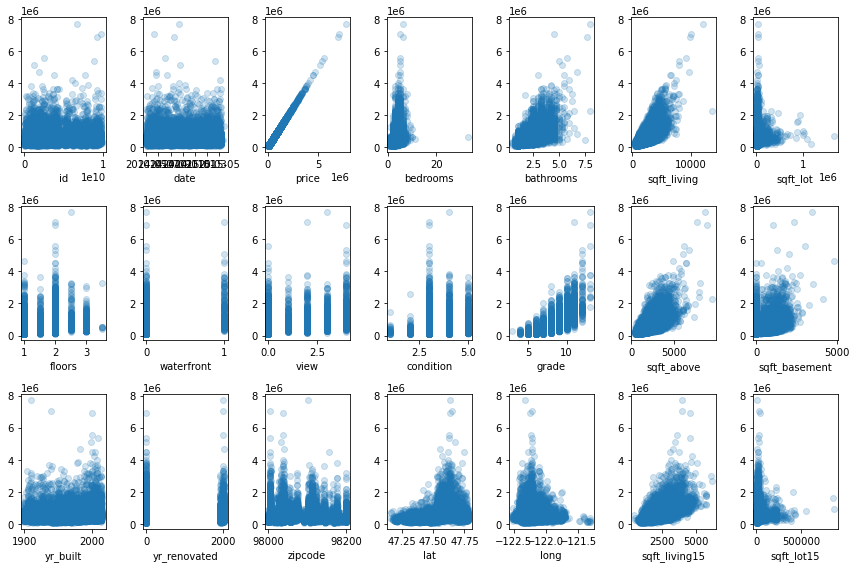

In [5]:
fig , axes = plt.subplots(nrows=3,ncols=7,figsize=(12,8))
fig.set_tight_layout(True)

for index,col in enumerate(dataset.columns):
    ax = axes[index//7][index%7]
    ax.scatter(dataset[col],dataset['price'],alpha=.2)
    ax.set_xlabel(col)

# Heatmap for a quick look at where we might start

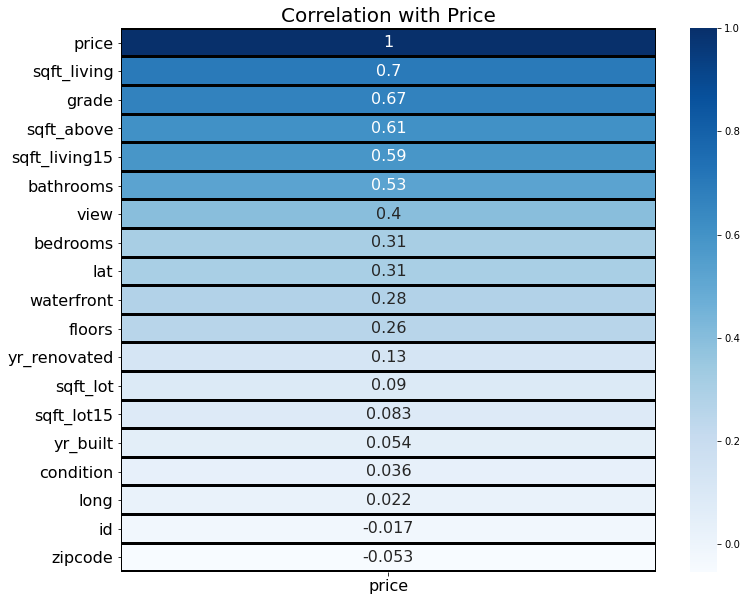

In [6]:
corr = df_train.corr()

x=corr[['price']]

fig , ax = plt.subplots(figsize=(12,10))

sns.heatmap(x.sort_values(by=['price'],ascending=0),
                          annot=True,
                          cmap='Blues',
                          annot_kws={'fontsize':16},
                          linewidth=2,
                          linecolor='black')
ax.set_title('Correlation with Price',size=20)
ax.tick_params(labelsize=16)
                          


 It seems like sqft_living has the highest correlation with price. This and grade seem to be the two highest, but grade is categorical (technically) and sqft is numerical.

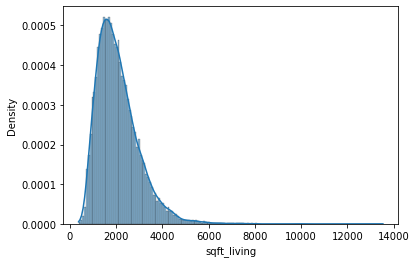

In [7]:
sns.histplot(df['sqft_living'],stat='density',kde=1);


Our data is skewed to the left.

In [8]:
df_zip = df.groupby('zipcode').mean().sort_values(by=['price'],ascending=False)
columns = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','condition','grade','sqft_living15','sqft_lot15']
new_df = pd.DataFrame(df_zip,columns=columns)
#new_df['avg_price_zipcode'] = df['zipcode'].map(lambda x: df['price'][x].mean())
price_df = new_df['price']
d = price_df.to_dict()
d

{'98039': 2161300.0,
 '98004': 1356523.9905362776,
 '98040': 1194873.6382978724,
 '98112': 1096239.0074349442,
 '98102': 899607.6730769231,
 '98109': 880077.752293578,
 '98105': 863228.9432314411,
 '98006': 859938.5542168674,
 '98119': 849714.8097826086,
 '98005': 810289.6964285715,
 '98033': 803990.8194444445,
 '98199': 792187.8738170346,
 '98075': 790734.704735376,
 '98074': 685675.8435374149,
 '98077': 682885.9898989899,
 '98053': 677215.034739454,
 '98177': 676419.3921568628,
 '98008': 645628.2261484099,
 '98052': 645244.2264808363,
 '98122': 634558.1448275862,
 '98115': 619944.1492281304,
 '98116': 618695.1090909091,
 '98007': 617254.0212765958,
 '98027': 617053.9660194175,
 '98029': 612642.738317757,
 '98144': 594706.5422740525,
 '98024': 586120.875,
 '98103': 585048.7790697674,
 '98107': 579109.8082706766,
 '98117': 576834.808318264,
 '98072': 570073.5201465201,
 '98136': 551768.5209125475,
 '98065': 529629.7824675324,
 '98034': 521740.0146788991,
 '98059': 493625.3098290598,
 '

In [9]:
df_grade = df.groupby('grade').mean().sort_values(by=['price'],ascending=False)
grade_df = pd.DataFrame(df_grade,columns=columns)
grade_df


,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,sqft_living15,sqft_lot15
grade,,,,,,,,,
13,3.710769e+06,4.846154,5.096154,7483.076923,28204.769231,3.153846,NaN,4005.384615,25529.461538
12,2.202528e+06,4.269663,4.025281,5479.022472,54819.213483,3.213483,NaN,3955.988764,39134.078652
11,1.497792e+06,4.160401,3.501880,4395.448622,38372.789474,3.195489,NaN,3532.110276,27743.160401
10,1.072347e+06,3.907407,3.006393,3520.299824,28191.063492,3.232804,NaN,3036.892416,21334.663139
9,7.737382e+05,3.773231,2.664340,2868.139962,20638.515488,3.266157,NaN,2613.460038,17401.707839
8,5.429868e+05,3.481616,2.348928,2184.803627,13514.009068,3.355647,NaN,2067.075845,11371.257049
7,4.025946e+05,3.258079,1.829953,1689.514932,11769.877089,3.491420,NaN,1679.280254,10615.995988
6,3.019166e+05,2.685967,1.243499,1191.561335,12646.953876,3.539745,NaN,1389.247301,11020.924926
3,2.620000e+05,1.000000,0.750000,520.000000,12981.000000,5.000000,NaN,1340.000000,12233.000000


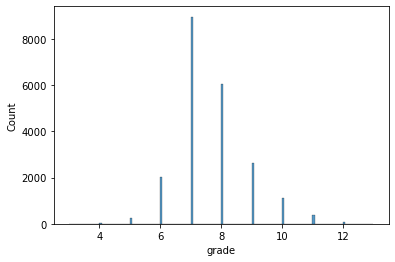

In [10]:
sns.histplot(df['grade']);

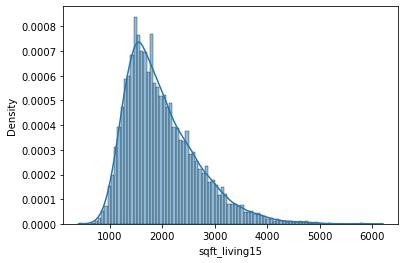

In [11]:
sns.histplot(df['sqft_living15'],stat='density',kde=1);

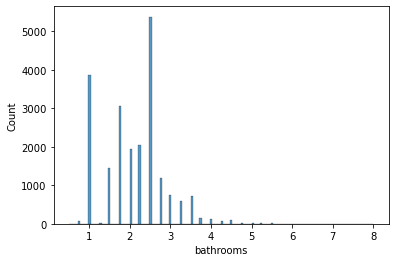

In [12]:
sns.histplot(df['bathrooms']);

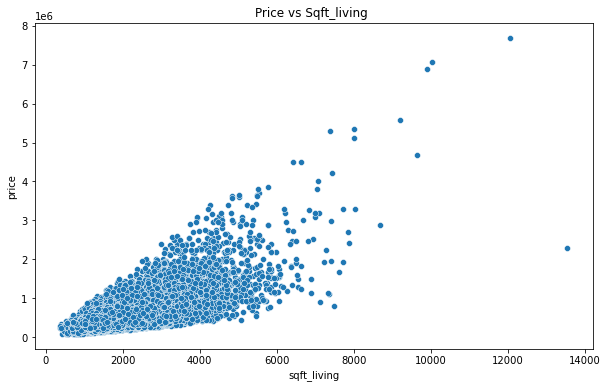

In [13]:
fig , (ax) = plt.subplots(figsize=(10,6))
ax.set_title('Price vs Sqft_living ')
sns.scatterplot(x=df['sqft_living'],y=df['price']);

Price and sqft_living seem to have a linear relationship based on this data.

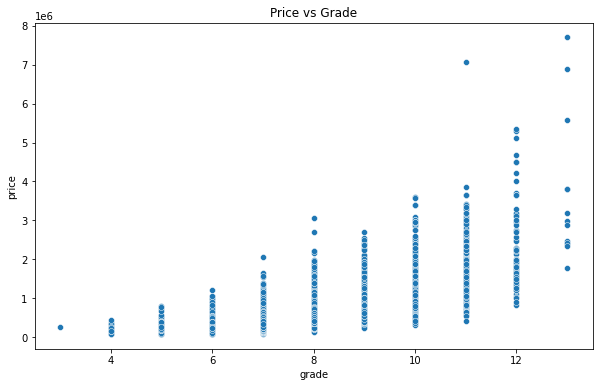

In [14]:
fig , (ax) = plt.subplots(figsize=(10,6))
ax.set_title('Price vs Grade')

sns.scatterplot(x=df['grade'],y=df['price']);

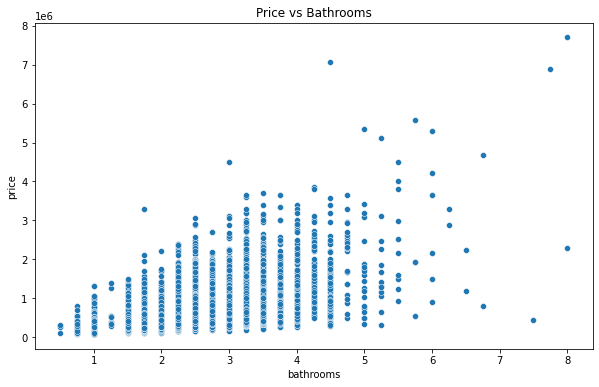

In [15]:
fig , (ax) = plt.subplots(figsize=(10,6))
ax.set_title('Price vs Bathrooms')

sns.scatterplot(x=df['bathrooms'],y=df['price']);

# Looking at score with most correlated feature

In [16]:
X = df['sqft_living']
y = df['price']


dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X,y)
dummy_regr.predict(X)
dummy_regr.score(X,y)

0.0

In [17]:
X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.array(X_train).reshape(-1,1)
Y_train = np.array(Y_train).reshape(-1,1)
X_test = np.array(X_test).reshape(-1,1)
Y_test = np.array(Y_test).reshape(-1,1)


model = LinearRegression()
model.fit(X_train,Y_train)

Y_pred = model.predict(X_test)

model.coef_,model.intercept_,model.score(X_train,Y_train),metrics.r2_score(Y_pred,Y_test)

(array([[282.20150555]]),
 array([-46447.34551807]),
 0.49249290659878187,
 0.02163804095839439)

In [18]:
formula = 'price ~ sqft_living + beds_baths +  grade_5 + grade_6 +  grade_8 + grade_9 +grade_10+grade_11+grade_12+grade_13' 
model = ols(formula, data=merged)
model.fit().summary()

PatsyError: Error evaluating factor: NameError: name 'beds_baths' is not defined
    price ~ sqft_living + beds_baths +  grade_5 + grade_6 +  grade_8 + grade_9 +grade_10+grade_11+grade_12+grade_13
                          ^^^^^^^^^^

Our first model uses one feature and can explain 49.2% of price variances. Y= 282.20*sqft - 46447 R2 = 49.2

In [ ]:
X = pd.DataFrame(df,columns = ['sqft_living','grade'])
y = df['price']

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X,y)
dummy_regr.predict(X)
dummy_regr.score(X,y)

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit(X_train).transform(X_train)

model = LinearRegression()
model.fit(X_train,Y_train)

y_hat = model.predict(X_train)

resid = Y_train-y_hat

Y_pred = model.predict(Scaler.transform(X_test))

model.coef_,model.intercept_,model.score(X_train,Y_train) , metrics.r2_score(Y_pred,Y_test) 


In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

In [ ]:
formula2 = 'price ~ sqft_living + grade '
model = ols(formula2, data=df_train)
model.fit().summary()


Our second model uses grade and square feet that gives us a better explanation of variances in price.
*Y= 183.33*sqft + 101962*grade - 621259 
R2 = 54%* 





In [ ]:
formula3 = 'price ~ sqft_living + grade + beds_baths + waterfront + condition'
model = ols(formula3, data=df)
model.fit().summary()

# An early model where we are exploring features

In [ ]:
X = pd.DataFrame(df,columns = ['sqft_living','grade','beds_baths','condition'])
y = df['price']

X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
ss = StandardScaler()
ss.fit(X).transform(X)

model.fit(X,y)

y_hat = model.predict(X_test)

resid = Y_test-y_hat

model.coef_,model.intercept_,model.score(X_train,Y_train), metrics.r2_score(y_hat,Y_test) 


This model performed poorly on the test set.

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

In [ ]:
#ss = StandardScaler()
#ss.fit(x)

#transform = ss.transform(x)
#transform

#lr = LinearRegression()
#lr.fit(x,y)

#y_hat = lr.predict(x)

#resid = (y - y_hat)

#plt.scatter(x=range(y_hat.shape[0]),y=resid, alpha=0.1)

In [ ]:
#X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

#model = LinearRegression()
#model.fit(X_train['sqft_living'],Y_train)
#Y_pred = model.predict(X_test)
#model.coef_ , model.intercept_
#mean_squared_error(Y_test,Y_pred) , mean_squared_error(Y_test,Y_pred,squared=False) 


In [ ]:
y_train_hat = lr.predict(X_train)
mse = mean_squared_error(Y_train,y_train_hat)
rmse = mean_squared_error(Y_train, y_train_hat, squared=False)
score = lr.score(X_train,Y_train)
score

print(f'Evaluate Model Prediction with Training Dataset:')
print('------------------------------------------------')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2: {score}')

In [ ]:
y_test_hat = lr.predict(X_test)
mse_test = mean_squared_error(Y_test,y_test_hat)
rmse_test = mean_squared_error(Y_test,y_test_hat,squared=False)
r2_test = lr.score(X_test,Y_test)

print(f'Evaluate Model Prediction with Testing Dataset:')
print('------------------------------------------------')
print(f'Testing Mean Squared Error: {mse_test}')
print(f'Testing Root Mean Squared Error: {rmse_test}')
print(f'Testing R^2: {r2_test}')

In [ ]:
#For each X, calculate VIF and save in dataframe
#vif = pd.DataFrame()
#vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#vif["features"] = X.columns


# R2 score with grades as dummy variables

In [ ]:
X=merged.drop(['price','id','date','sqft_lot','sqft_above','grade'], axis = 1).select_dtypes(exclude = ['object', 'category'])
y=merged['price']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
baseline_model.coef_, baseline_model.intercept_, baseline_model.score(X_train, y_train), baseline_model.score(X_test, y_test)

Explaining variances at 73%, this is our best model we have come up with.

# R2 Score with Grade as Normal

In [ ]:
X = dataset.drop(['price','id','date','sqft_lot','sqft_above','view'], axis = 1).select_dtypes(exclude = ['object', 'category'])
#X = X.drop(['id','date','sqft_lot','sqft_above'],axis=1)
y=dataset['price']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
baseline_model.coef_, baseline_model.intercept_, baseline_model.score(X_train, y_train), baseline_model.score(X_test, y_test)

This model performs lower on the testing set, meaning the dummy variables helped with our R2.

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

In [ ]:
heatmap_data=pd.concat([Y_train,X],axis=1)

fig , ax = plt.subplots(figsize=(20,20))

sns.heatmap(heatmap_data.corr(),annot=True)

In [ ]:
X=merged.drop(['price','id','date','sqft_lot','sqft_above','grade','sqft_living15','bathrooms','grade_7'], axis = 1).select_dtypes(exclude = ['object', 'category'])
y=merged['price']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
baseline_model.coef_, baseline_model.intercept_, baseline_model.score(X_train, y_train), baseline_model.score(X_test, y_test)

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

In [39]:
X=merged.drop(['id','date','view','sqft_lot','grade_7','sqft_above','grade','sqft_living15','bathrooms','sqft_lot15','lat','long','yr_built','bedrooms','sqft_basement','floors','condition'], axis = 1).select_dtypes(exclude = ['object', 'category'])
y=merged['price']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

group = X_train.groupby('zipcode').mean().sort_values(by=['price'],ascending=False)
zip_group = group['price']
zip_dict = zip_group.to_dict()
X_train['avg_zip_price'] = X_train['zipcode'].map(zip_dict)
X_train.drop('price',inplace=True,axis=1)
X_train

<ipython-input-39-99b70cd3ab6a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['avg_zip_price'] = X_train['zipcode'].map(zip_dict)
C:\Users\mmcel\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,sqft_living,waterfront,yr_renovated,zipcode,grade_4,grade_5,grade_6,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,avg_zip_price
15714,1350,0.0,1959.0,98004,0,0,0,0,0,0,0,0,0,1.343674e+06
10920,1830,0.0,1928.0,98040,0,0,0,0,0,0,0,0,0,1.198157e+06
2782,3527,0.0,2005.0,98198,0,0,0,0,0,0,0,0,0,3.051686e+05
14991,1920,0.0,0.0,98027,0,0,0,1,0,0,0,0,0,6.081606e+05
19542,1980,0.0,1910.0,98119,0,0,0,1,0,0,0,0,0,8.556661e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11323,3400,0.0,0.0,98038,0,0,0,0,1,0,0,0,0,3.684502e+05
12006,2430,0.0,1952.0,98004,0,0,0,1,0,0,0,0,0,1.343674e+06
5409,1620,0.0,0.0,98125,0,0,1,0,0,0,0,0,0,4.666638e+05
866,3460,0.0,0.0,98056,0,0,0,0,0,0,0,0,0,4.130930e+05


In [40]:
X_test['avg_zip_price'] = X_test['zipcode'].map(zip_dict)
X_test.drop('price',inplace=True,axis=1)
X_test


<ipython-input-40-d9cb97517490>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['avg_zip_price'] = X_test['zipcode'].map(zip_dict)
C:\Users\mmcel\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,sqft_living,waterfront,yr_renovated,zipcode,grade_4,grade_5,grade_6,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,avg_zip_price
19009,3100,0.0,0.0,98103,0,0,0,0,0,0,0,0,0,5.789110e+05
6370,3610,0.0,0.0,98075,0,0,0,0,0,1,0,0,0,7.920995e+05
13983,1070,0.0,0.0,98002,0,0,1,0,0,0,0,0,0,2.326277e+05
7837,4010,0.0,1990.0,98004,0,0,0,1,0,0,0,0,0,1.343674e+06
9491,1930,0.0,0.0,98155,0,0,0,1,0,0,0,0,0,4.305656e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5005,620,0.0,0.0,98117,0,0,1,0,0,0,0,0,0,5.727042e+05
14640,2300,0.0,0.0,98053,0,0,1,0,0,0,0,0,0,6.814280e+05
19802,2710,0.0,0.0,98038,0,0,0,1,0,0,0,0,0,3.684502e+05
1012,1780,0.0,0.0,98008,0,0,0,1,0,0,0,0,0,6.512965e+05


In [41]:
#X=merged.drop(['price','id','date','sqft_lot','sqft_above','grade','grade_7','sqft_living15','bathrooms','sqft_lot15','lat','long','yr_built','bedrooms','sqft_basement','floors','condition'], axis = 1).select_dtypes(exclude = ['object', 'category'])
#y=merged['price']

#X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

final_model = LinearRegression()
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
final_model.coef_, final_model.intercept_, final_model.score(X_train, y_train), final_model.score(X_test, y_test)

(array([ 1.37037952e+05,  6.94419075e+04,  7.10894211e+03,  3.04836680e+04,
        -7.92535494e+01,  6.68175219e+00,  7.75898092e+00,  8.34049041e+03,
         2.97977723e+04,  4.80915240e+04,  6.00796396e+04,  5.56939314e+04,
         3.27961303e+04,  1.61486783e+05]),
 538633.7840599025,
 0.7835730244009957,
 0.7935934061690587)

In [42]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,8.219262,price
1,17.598884,sqft_living
2,1.106102,waterfront
3,1.276331,yr_renovated
4,11.444621,zipcode
5,1.007044,grade_4
6,1.045038,grade_5
7,1.298158,grade_6
8,1.902923,grade_8
9,1.873330,grade_9


# Investigating Linearity

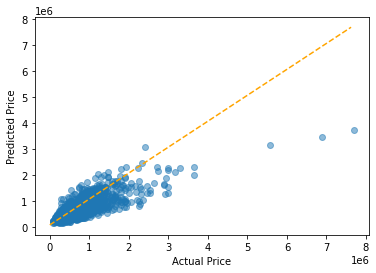

In [47]:
preds = final_model.predict(X_test)
fig, ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line, linestyle = '--', color = 'orange', label = "Perfect Fit")
ax.scatter(y_test, preds, alpha=.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price");


# Investigating Normality

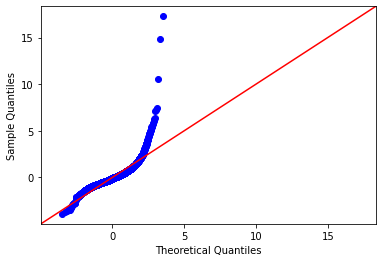

In [48]:
residuals = (y_test - y_pred)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

# Investigating Homoskedasticity

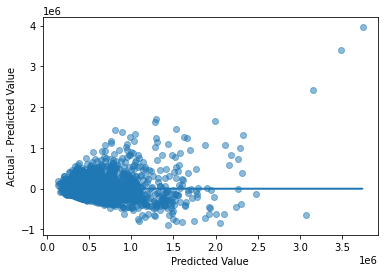

In [49]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");